In [1]:
from pathlib import Path
from astropy.io import fits
from skimage.transform import resize
import cv2
from PIL import Image
import imutils
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import signal
import scipy.stats as stats

In [39]:
def analyse_pupil(pupil, phase=1, Nimg= 0):
    fig = plt.figure(1, figsize=(15,9))
    gs = gridspec.GridSpec(2,3,height_ratios=[1,1], width_ratios=[1,1,1])
    gs.update(left=0.01, right=0.95, bottom=0.02, top=0.75, wspace=0.3, hspace=0.30)

    apperture_dim = np.shape(pupil)[0] #equivalent to varying the wavelength
    print('Size of frame:', apperture_dim, 'px')
    if np.size(phase) == 1:
        phase = np.zeros((apperture_dim,apperture_dim))
    pupil_complex = pupil * np.exp(1j*phase*pupil)
    if Nimg == 0:
        Nimg = apperture_dim//2
    
    #1- Display pupil complex: amplitude
    ax = plt.subplot(gs[0,0]) 
    plt.title('Input pupil: amplitude')
    im = ax.imshow(np.abs(pupil_complex), cmap='CMRmap', origin='lower',interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    #2- Display pupil complex
    ax = plt.subplot(gs[1,0]) 
    plt.title('Input pupil: phase')
    im = ax.imshow(np.angle(pupil_complex), cmap='CMRmap', origin='lower',interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    
    #3- Building the PSF 
    psf = np.abs(np.fft.fftshift(np.fft.fft2(pupil_complex)))**2 
    psf_norm = psf/np.max(psf)
    psf_crop = psf_norm[apperture_dim//2-Nimg//2:apperture_dim//2+Nimg//2,apperture_dim//2-Nimg//2:apperture_dim//2+Nimg//2]
    ax = plt.subplot(gs[0,1]) 
    im = ax.imshow((psf_crop)**0.1, cmap='CMRmap', origin='lower',interpolation='nearest')
    plt.title('PSF: |FT[pupil]|**2')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    #4- Profile of the PSF
    x_sup = np.arange(-apperture_dim//2,apperture_dim//2)
    prof_psf_xdir = psf_norm[apperture_dim//2,apperture_dim//2:]
    prof_psf_ydir = psf_norm[apperture_dim//2:,apperture_dim//2]
    prof_psf_circ = mean_profile(psf_crop)
    for psf_resolution in range(apperture_dim//2):
        if prof_psf_circ[psf_resolution+1] > prof_psf_circ[psf_resolution]:
            break
    print('Resolution from PSF:', psf_resolution, 'px')        
   
    ax = plt.subplot(gs[0,2]) 
    plt.title('Profile of the PSF')
    ax.semilogy(x_sup[apperture_dim//2:apperture_dim//2+Nimg//2],prof_psf_circ)
    plt.axvline(x=psf_resolution, color='r', ls = '--', lw=0.8, alpha=0.6, \
                label='Resolution PSF: {0:.2f} px'.format(psf_resolution))
    plt.xlim([0,Nimg//2])
    plt.ylim([1/1e6,1.0])
    plt.legend(frameon=False)

    
    #5- MTF (via PSF)
    otf_psf = np.fft.fftshift(np.fft.fft2(psf_norm))
    mtf_psf = np.abs(otf_psf)
    ax = plt.subplot(gs[1,1]) 
    im = ax.imshow(mtf_psf, cmap='CMRmap', origin='lower',interpolation='nearest')
    plt.title('MTF: |FT[PSF]|')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    #5- Phase (via PSF)
    #phase_psf = np.angle(otf_psf)
    #ax = plt.subplot(gs[1,2]) 
    #im = ax.imshow(phase_psf, cmap='CMRmap', origin='lower',interpolation='nearest')
    #plt.title('OTF: arg{FT[PSF]}')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(im, cax=cax)

    #6- Profile of the OTF from the PSF
    prof_otf_xdir = mtf_psf[apperture_dim//2,apperture_dim//2:]
    prof_otf_ydir = mtf_psf[apperture_dim//2:,apperture_dim//2]
    prof_otf_circ = mean_profile(mtf_psf)
    cutoff_fcy = 1.
    w = np.where(prof_otf_circ < 1e-10, prof_otf_circ, -1)
    for i in range(np.shape(w)[0]):
        if w[i] != -1:
            cutoff_fcy=i
            break
    otf_resolution = apperture_dim/cutoff_fcy
    print('Cutoff frequency from MTF:', cutoff_fcy, 'px')        
    print('Resolution from MTF:', otf_resolution, 'px')        
    ax = plt.subplot(gs[1,2]) 
    plt.title('Profile of the OTF')
    ax.plot(x_sup[apperture_dim//2:],prof_otf_xdir/np.max(prof_otf_xdir), ls = '--',color='orange')
    ax.plot(x_sup[apperture_dim//2:],prof_otf_ydir/np.max(prof_otf_ydir), ls = '--',color='orange')
    ax.plot(x_sup[apperture_dim//2:],prof_otf_circ/np.max(prof_otf_circ),color='green')
    plt.ylim([0,1])
    plt.xlim([0,apperture_dim/2])
    plt.axvline(x=0, color='black', ls = '--', lw=0.8, alpha=0.6)
    plt.axvline(x=cutoff_fcy, color='r', ls = '--', lw=0.8, alpha=0.6, \
                label='Cutoff Frequency: {0:.2f} px'.format(cutoff_fcy))
    plt.legend(frameon=False)


#print(np.sum(pupil))
#print(np.max(otf_psf))

In [5]:
def mk_pupilc(radius,Nframe):
    P = np.zeros((Nframe,Nframe))#,dtype=complex)
    for k in range(Nframe):
            for m in range(Nframe):
                if pow((k-Nframe/2)*(k-Nframe/2)+(m-Nframe/2)*(m-Nframe/2),0.5) < radius:
                    P[k,m] = 1.0
    return P

In [6]:
def mk_pupil(radius, Nx, Ny, xc, yc):
    Mx = np.maximum(Nx,Ny)
    My = np.minimum(Nx,Ny)
    P = np.zeros((Nx,Ny))#, dtype='complex')
    for k in range(Mx):
            for m in range(My):
                if pow((k-xc)*(k-xc)+(m-yc)*(m-yc),0.5) < radius:
                    if Mx == Nx:
                        P[k,m] = 1.0
                    else: 
                        P[m,k] = 1.0
    return P

In [7]:
def mean_profile(image, step=1):
    x, y = np.shape(image)
    cc = np.shape(image)[0]//2
    newy, newx = np.mgrid[:y,:x]
    circ = np.sqrt((newx-cc)**2 + (newy-cc)**2)
    mean_ann = np.zeros(cc)
    for i in range(0,cc,step):
        circ_ext = np.where((circ < i+step), 1, 0)
        circ_int = np.where((circ >=  i), 1, 0)
        ann = circ_int*circ_ext
        idm = np.where(ann !=0)
        mean_ann[i]=np.mean(image[idm])
    return mean_ann

## 1. Full circular pupil

Size of frame: 256 px
Resolution from PSF: 2 px
Cutoff frequency from MTF: 1.0 px
Resolution from MTF: 256.0 px


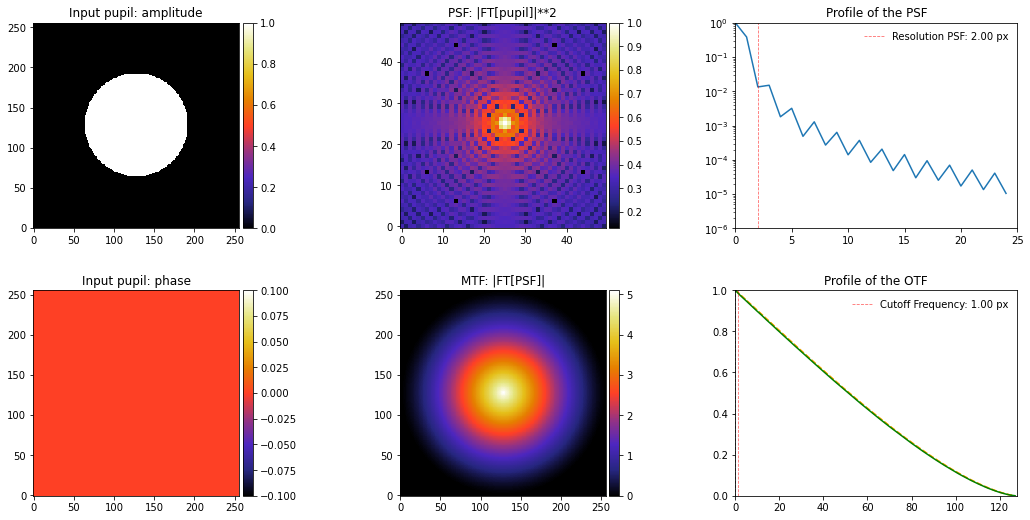

In [12]:
pupil = mk_pupilc(64,256)
analyse_pupil(pupil,Nimg=50)

Size of frame: 256 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 1.0 px
Resolution from MTF: 256.0 px


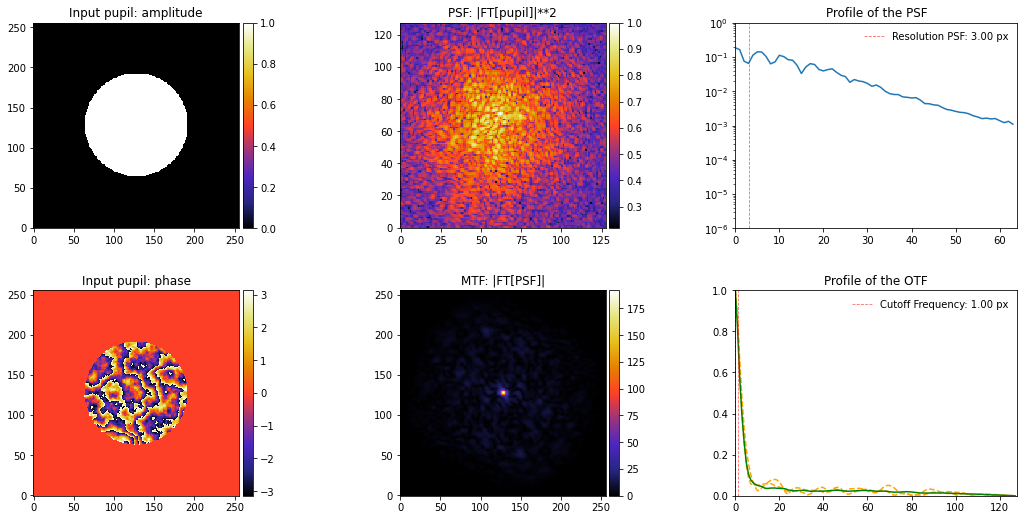

In [10]:
dir_pha = Path('./Phases/')
pupil = mk_pupilc(64,256)
phase_turb = fits.getdata(dir_pha.joinpath('phi_res_turb.fits'))
analyse_pupil(pupil,phase_turb)

Size of frame: 256 px
Resolution from PSF: 2 px
Cutoff frequency from MTF: 1.0 px
Resolution from MTF: 256.0 px


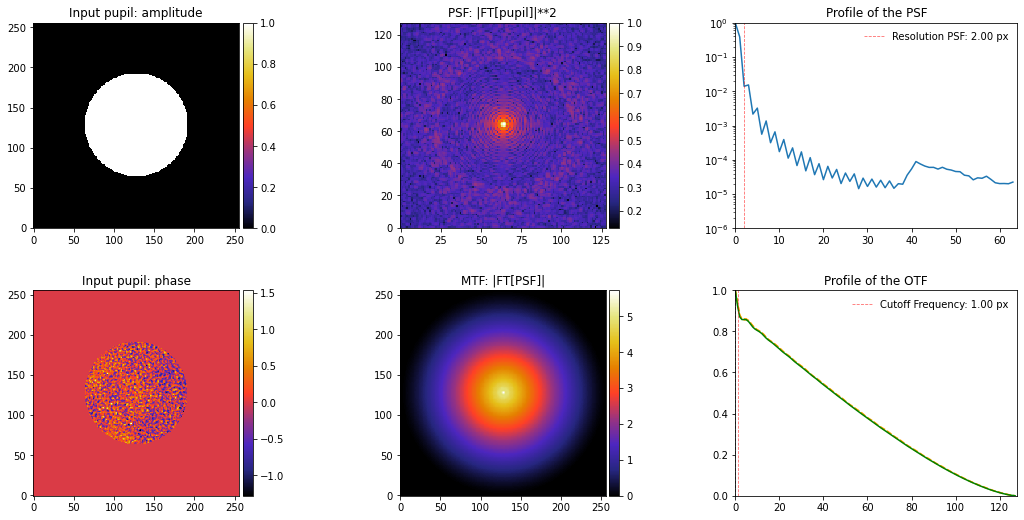

In [11]:
dir_pha = Path('./Phases/')
pupil = mk_pupilc(64,256)
phase_ao = fits.getdata(dir_pha.joinpath('phi_res_ao.fits'))
analyse_pupil(pupil,phase_ao)

## 2. SAM pupil

Size of frame: 256 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 93 px
Resolution from MTF: 2.752688172043011 px


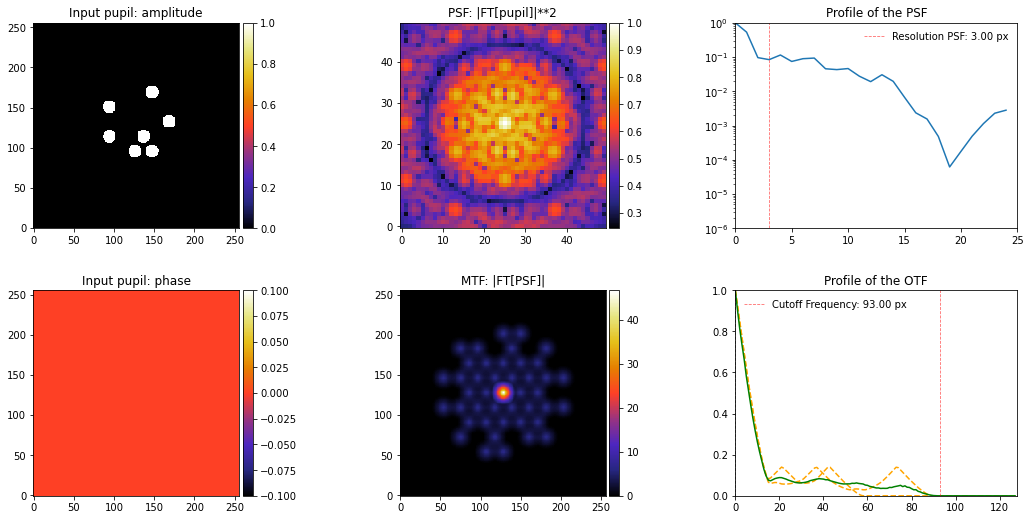

In [37]:
dir_pup = Path('/Users/fcantalloube/Work/Wind_Driven_Halo/SPHERE_info/Pupils_384x384_pixcentral/')
sph_sam = fits.getdata(dir_pup.joinpath('SAM_IRDIS_binary_256x256px.fits'))
analyse_pupil(sph_sam,Nimg=50)

Size of frame: 256 px
Resolution from PSF: 2 px
Cutoff frequency from MTF: 93 px
Resolution from MTF: 2.752688172043011 px


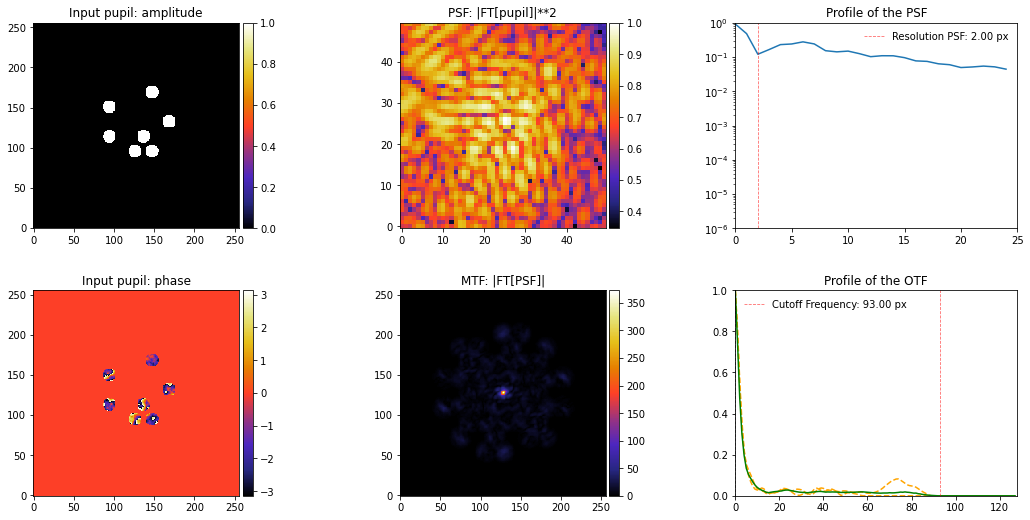

In [40]:
analyse_pupil(sph_sam,phase_turb,Nimg=50)

Size of frame: 256 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 93 px
Resolution from MTF: 2.752688172043011 px


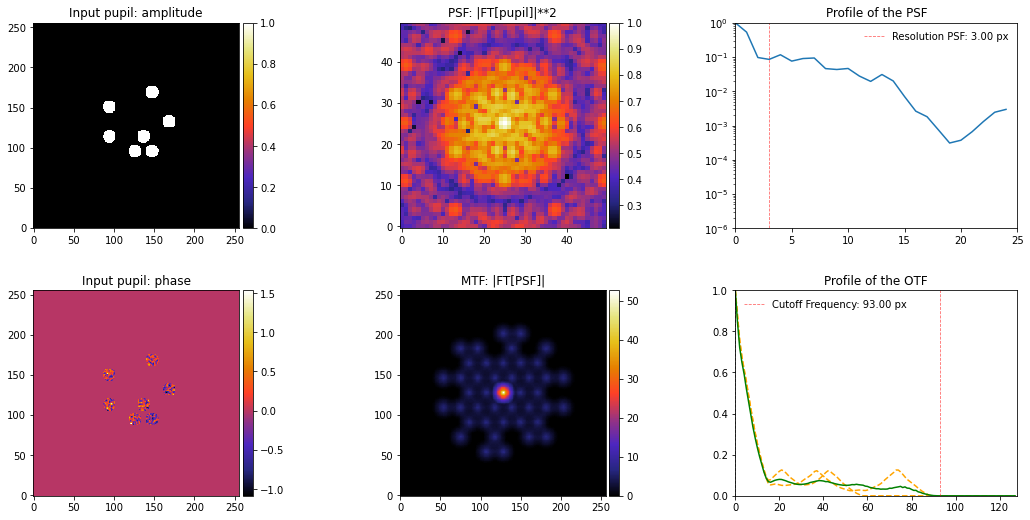

In [41]:
analyse_pupil(sph_sam,phase_ao,Nimg=50)